In [1]:
!pip install annoy scikit-learn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552447 sha256=477b5d1524c57b137cc982cabcf020f66168662ac975e2c5164e9da42678e011
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [2]:
from annoy import AnnoyIndex
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
from tabulate import tabulate
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

In [ ]:
# Bước 1: Đọc và làm sạch dữ liệu (Read and clean data)
df = pd.read_csv('dataset.csv')
df = df.fillna('')

In [ ]:
# Bước 2: Chuyển đổi dữ liệu dạng văn bản thành vector số (Text to numerical vectors)
tfidf_name = TfidfVectorizer()
tfidf_matrix_name = tfidf_name.fit_transform(df['product_name'])

tfidf_category = TfidfVectorizer()
tfidf_matrix_category = tfidf_category.fit_transform(df['category'])

tfidf_sub_category = TfidfVectorizer()
tfidf_matrix_sub_category = tfidf_sub_category.fit_transform(df['sub_category'])

tfidf_item = TfidfVectorizer()
tfidf_matrix_item = tfidf_item.fit_transform(df['item'])

tfidf_description = TfidfVectorizer()
tfidf_matrix_description = tfidf_description.fit_transform(df['about_product'])

In [ ]:
# Bước 3: Chuẩn hóa dữ liệu số (Normalize numerical data)
numerical_features = df[['price']].values
scaler = MinMaxScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features)

In [ ]:
# Bước 4: Kết hợp tất cả các vector đặc trưng
features = np.hstack([tfidf_matrix_name.toarray(),
                   tfidf_matrix_category.toarray(),
                   tfidf_matrix_sub_category.toarray(),
                   tfidf_matrix_item.toarray(),
                   tfidf_matrix_description.toarray(),
                   numerical_features_scaled.reshape(-1, 1)])

In [ ]:
# Bước 5: Tạo Annoy index (Create Annoy index)
num_features = features.shape[1]
annoy_index = AnnoyIndex(num_features, 'angular')  # 'angular' for cosine similarity

start_time = time.time()
for i, feature_vector in enumerate(features):
    annoy_index.add_item(i, feature_vector)

annoy_index.build(10) # Build the index with 10 trees
annoy_index.save('product_annoy_index.ann')
annoy_build_time = time.time() - start_time

In [ ]:
# Hàm để lấy top n sản phẩm tương tự bằng Brute-force (Brute-force function)
def get_top_n_similar_products_bruteforce(product_id, n=5):
    product_index = df.index[df['product_id'] == product_id][0]
    start_time = time.time()
    similarity_scores = cosine_similarity([features[product_index]], features).flatten()
    bruteforce_query_time = time.time() - start_time

    top_indices = np.argsort(similarity_scores)[-n-1:-1][::-1]
    similar_indices = [i for i in top_indices if i != product_index][:n]

    similar_products = df.iloc[similar_indices].copy()
    similar_products['similarity'] = similarity_scores[similar_indices]
    print(f"Top {n} sản phẩm tương tự (Brute-force) '{df.iloc[product_index]['product_name']}':")
    print(tabulate(similar_products[['product_id', 'similarity', 'product_name', 'item', 'price', 'rating']], headers='keys', tablefmt='psql'))
    print('\n')
    return bruteforce_query_time

In [ ]:
# Hàm để lấy top n sản phẩm tương tự bằng Annoy (Annoy function)
def get_top_n_similar_products_annoy(product_id, n=5, search_k=1000):
    product_index = df.index[df['product_id'] == product_id][0]
    start_time = time.time()
    similar_indices = annoy_index.get_nns_by_item(product_index, n + 1, search_k=search_k)[1:]
    annoy_query_time = time.time() - start_time
    similar_indices = [i for i in similar_indices if i != product_index][:n]

    similar_products = df.iloc[similar_indices].copy()
    similarity_scores = cosine_similarity([features[product_index]], features[similar_indices]).flatten()
    similar_products['similarity'] = similarity_scores

    print(f"Top {n} sản phẩm tương tự (Annoy) '{df.iloc[product_index]['product_name']}':")
    print(tabulate(similar_products[['product_id', 'similarity', 'product_name', 'item', 'price', 'rating']], headers='keys', tablefmt='psql'))
    print('\n')
    return annoy_query_time

In [ ]:
# Ví dụ sử dụng và đánh giá (Example usage and evaluation)
product_id = 'B082T6V3DT' # Chọn một product_id để so sánh

# Annoy
annoy_query_time = get_top_n_similar_products_annoy(product_id, n=5) # Gán giá trị trả về

# Brute-force
bruteforce_query_time = get_top_n_similar_products_bruteforce(product_id, n=5) # Gán giá trị trả về

print(f"Thời gian truy vấn Annoy: {annoy_query_time:.4f} giây")
print(f"Thời gian truy vấn Brute-force: {bruteforce_query_time:.4f} giây")

Top 5 sản phẩm tương tự (Annoy) 'AmazonBasics New Release Nylon USB-A to Lightning Cable Cord, Fast Charging MFi Certified Charger for Apple iPhone, iPad (6-Ft, Rose Gold)':
+-----+--------------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------+-----------+---------+----------+
|     | product_id   |   similarity | product_name                                                                                                                                | item      |   price |   rating |
|-----+--------------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------+-----------+---------+----------|
| 101 | B082T6GVLJ   |     0.983475 | Amazon Basics New Release Nylon USB-A to Lightning Cable Cord, Fast Charging MFi Certified Charger for Apple iPhone, iPad (3-Ft, Rose Gold) | USBCabl

In [ ]:
# Ví dụ sử dụng và đánh giá (Example usage and evaluation)
product_id = 'B06XPYRWV5' # Chọn một product_id để so sánh

# Annoy
annoy_query_time = get_top_n_similar_products_annoy(product_id, n=5) # Gán giá trị trả về

# Brute-force
bruteforce_query_time = get_top_n_similar_products_bruteforce(product_id, n=5) # Gán giá trị trả về

print(f"Thời gian truy vấn Annoy: {annoy_query_time:.4f} giây")
print(f"Thời gian truy vấn Brute-force: {bruteforce_query_time:.4f} giây")

Top 5 sản phẩm tương tự (Annoy) 'Pigeon by Stovekraft 2 Slice Auto Pop up Toaster. A Smart Bread Toaster for Your Home (750 Watt) (black)':
+------+--------------+--------------+----------------------------------------------------------------------------+-------------------+---------+----------+
|      | product_id   |   similarity | product_name                                                               | item              |   price |   rating |
|------+--------------+--------------+----------------------------------------------------------------------------+-------------------+---------+----------|
| 1103 | B0073QGKAS   |     0.781519 | Bajaj ATX 4 750-Watt Pop-up Toaster (White)                                | Pop-upToasters    |    1499 |      4.3 |
| 1033 | B071VNHMX2   |     0.690074 | Philips Daily Collection HD2582/00 830-Watt 2-Slice Pop-up Toaster (White) | Pop-upToasters    |    2095 |      4.5 |
| 1307 | B07P1BR7L8   |     0.476018 | Philips HD6975/00 25 Litre Digital O

In [ ]:
def compare_performance_item_to_item():
    num_queries = 100
    bruteforce_times = []
    annoy_times = []

    for _ in range(num_queries):
        product_id = df.sample()['product_id'].iloc[0]

        # Brute-force
        start_time = time.time()
        get_top_n_similar_products_bruteforce(product_id, n=5)
        bf_time = time.time() - start_time
        bruteforce_times.append(bf_time)

        # Annoy
        start_time = time.time()
        get_top_n_similar_products_annoy(product_id, n=5)
        annoy_time = time.time() - start_time
        annoy_times.append(annoy_time)

    return bruteforce_times, annoy_times

In [ ]:
def plot_performance_comparison(bruteforce_times, annoy_times):
    plt.figure(figsize=(15, 15))

    # Histogram for Brute-force
    plt.subplot(3, 2, 1)
    plt.hist(bruteforce_times, bins=20, edgecolor='black', alpha=0.7)
    plt.title('Brute-force')
    plt.xlabel('Thời gian (giây)')
    plt.ylabel('Số lượng truy vấn')

    # Histogram for Annoy
    plt.subplot(3, 2, 2)
    plt.hist(annoy_times, bins=20, edgecolor='black', alpha=0.7)
    plt.title('Annoy')
    plt.xlabel('Thời gian (giây)')
    plt.ylabel('Số lượng truy vấn')

    # Box plot comparison
    plt.subplot(3, 2, (3, 4))
    plt.boxplot([bruteforce_times, annoy_times], labels=['Brute-force', 'Annoy'])
    plt.title('So sánh thời gian truy vấn')
    plt.ylabel('Thời gian (giây)')

    # Performance statistics table
    table_data = [
        ["Thuật toán", "Thời gian truy vấn (ms)", "Truy vấn/giây"],
        ["Brute-force", f"{np.mean(bruteforce_times) * 1000:.2f}", f"{1 / np.mean(bruteforce_times):.2f}"],
        ["Annoy", f"{np.mean(annoy_times) * 1000:.2f}", f"{1 / np.mean(annoy_times):.2f}"],
    ]

    plt.subplot(3, 2, (5, 6))
    plt.axis('off')
    table = plt.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    plt.title('Bảng: So sánh hiệu suất')

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_performance_comparison(bruteforce_times, annoy_times):
    plt.figure(figsize=(15, 15))

    # Histogram for Brute-force
    plt.subplot(3, 2, 1)
    plt.hist(bruteforce_times, bins=20, edgecolor='black', alpha=0.7)
    plt.title('Brute-force')
    plt.xlabel('Thời gian (giây)')
    plt.ylabel('Số lượng truy vấn')

    # Histogram for Annoy
    plt.subplot(3, 2, 2)
    plt.hist(annoy_times, bins=20, edgecolor='black', alpha=0.7)
    plt.title('Annoy')
    plt.xlabel('Thời gian (giây)')
    plt.ylabel('Số lượng truy vấn')

    # Box plot comparison
    plt.subplot(3, 2, (3, 4))
    plt.boxplot([bruteforce_times, annoy_times], labels=['Brute-force', 'Annoy'])
    plt.title('So sánh thời gian truy vấn')
    plt.ylabel('Thời gian (giây)')

    # Performance statistics table
    table_data = [
        ["Thuật toán", "Thời gian truy vấn (ms)", "Truy vấn/giây"],
        ["Brute-force", f"{np.mean(bruteforce_times) * 1000:.2f}", f"{1 / np.mean(bruteforce_times):.2f}"],
        ["Annoy", f"{np.mean(annoy_times) * 1000:.2f}", f"{1 / np.mean(annoy_times):.2f}"],
    ]

    plt.subplot(3, 2, (5, 6))
    plt.axis('off')
    table = plt.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    # Thêm các thuộc tính này để điều chỉnh màu sắc và kiểu dáng của bảng
    table.auto_set_column_width(col=list(range(len(table_data[0]))))
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#4472C4')
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('black')

    plt.title('Bảng: So sánh hiệu suất')

    plt.tight_layout()
    plt.show()

Top 5 sản phẩm tương tự (Brute-force) 'Kitchenwell Multipurpose Portable Electronic Digital Weighing Scale Weight Machine | Weight Machine | 10 Kg':
+------+--------------+--------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+---------+----------+
|      | product_id   |   similarity | product_name                                                                                                                                                                                        | item                 |   price |   rating |
|------+--------------+--------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+---------+----------|
| 1012 |

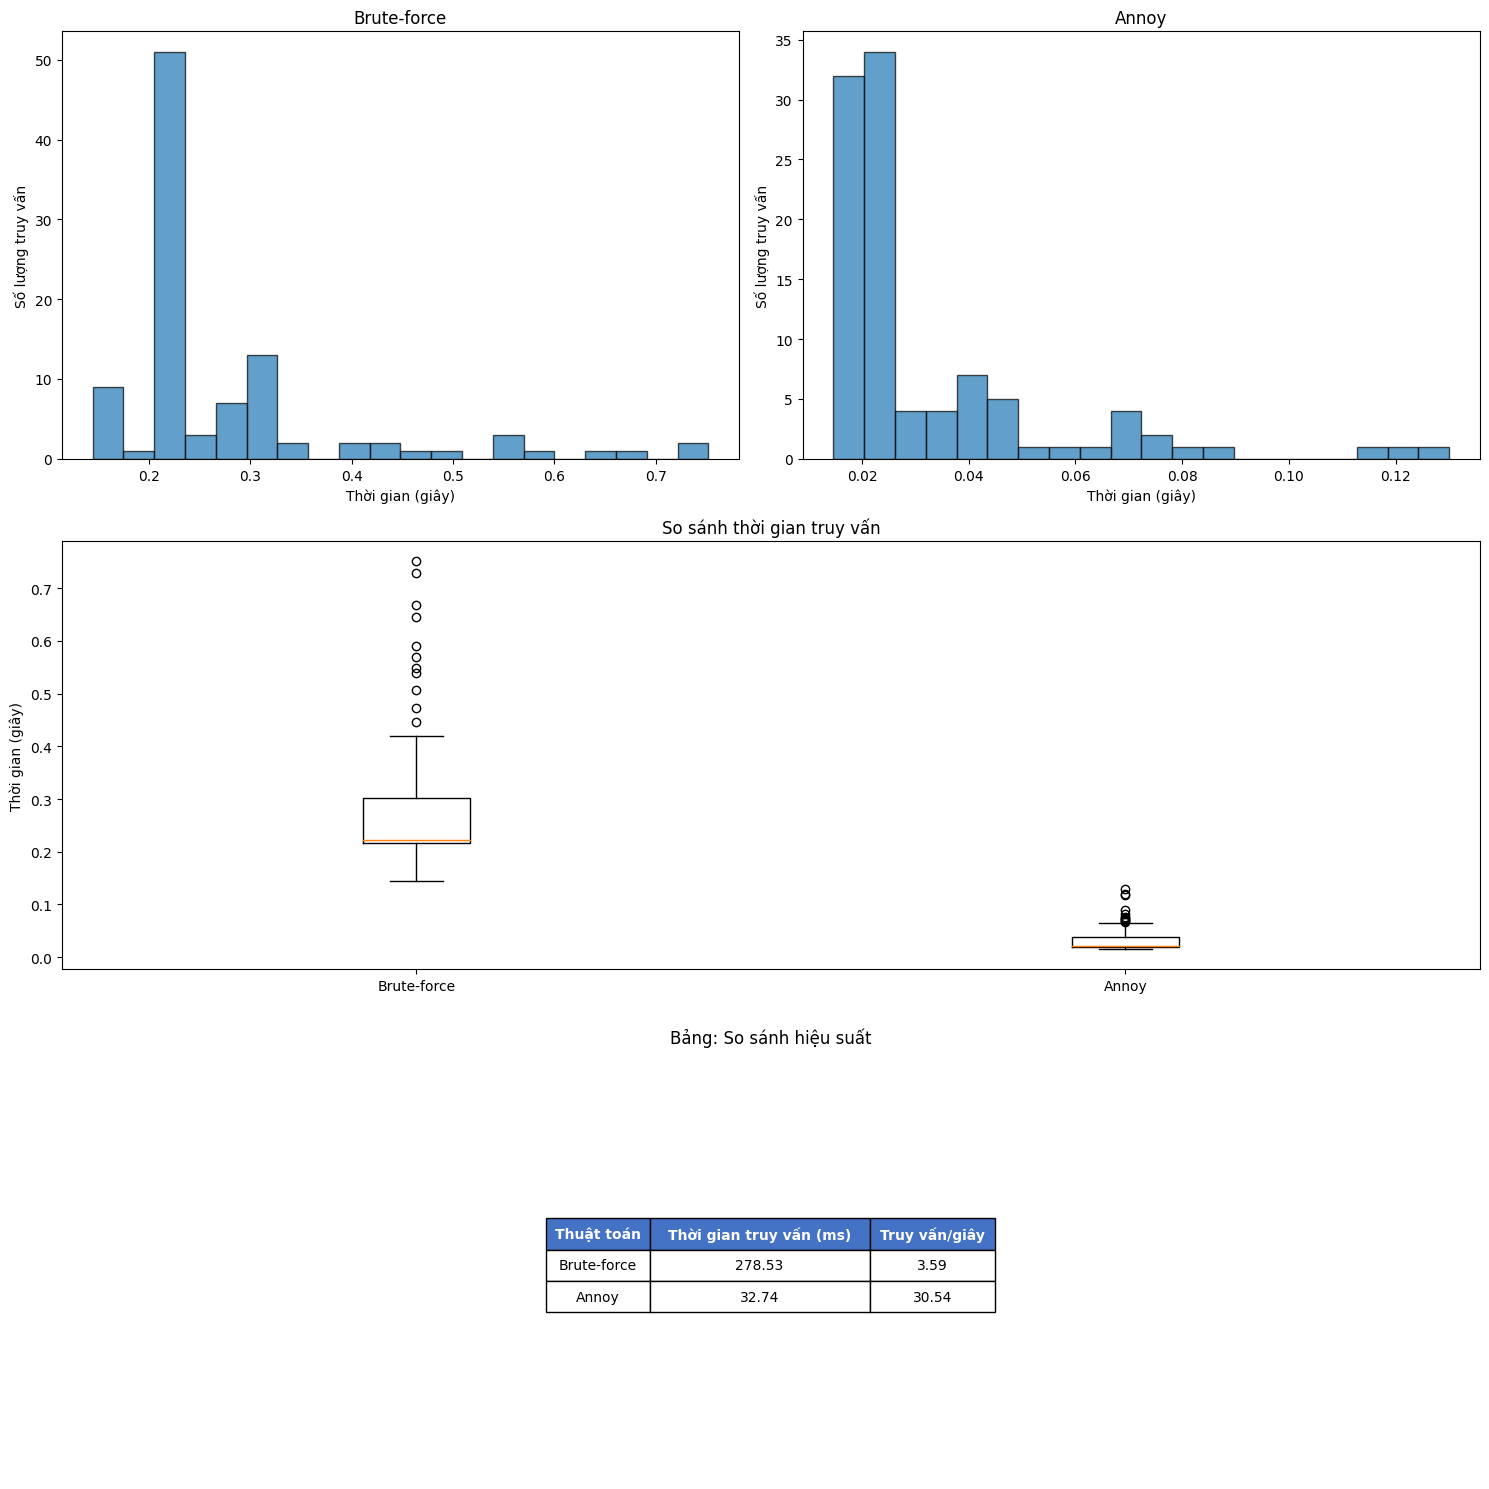

In [ ]:
# Run the performance comparison
bruteforce_times, annoy_times = compare_performance_item_to_item()
plot_performance_comparison(bruteforce_times, annoy_times)